In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os
import urllib.request
from astropy.io import fits 
from astropy.table import Table

from sklearn.decomposition import PCA
from sklearn.neighbors import KernelDensity
from astroML.utils.decorators import pickle_results
plt.rcParams.update({
  "text.usetex": True,
  "font.family": "Helvetica"
})


In [24]:
#Definición de funciones

#Grafica las decomposiciones
def plotdecom(decompositions):
    n_components = len(decompositions)
    fig = plt.figure(figsize=(5, n_components))
    fig.subplots_adjust(left=0.05, right=0.95, wspace=0.05,
                        bottom=0.1, top=0.95, hspace=0.05)

    titles='PCA components'
    i=1

    for j in range(n_components):
        ax = fig.add_subplot(n_components,1,j+1)

        ax.yaxis.set_major_formatter(plt.NullFormatter())
        ax.xaxis.set_major_locator(plt.MultipleLocator(1000))
        if j < n_components - 1:
            ax.xaxis.set_major_formatter(plt.NullFormatter())
        else:
            ax.xaxis.set_major_locator(
                plt.FixedLocator(list(range(3000, 11999, 1000))))
            ax.set_xlabel(r'wavelength ${\rm (\AA)}$')

        ax.plot(10**logwave, decompositions[j], '-k', lw=1)

        # plot zero line
        xlim = [3000, 11000]
        ax.plot(xlim, [0, 0], '-', c='gray', lw=1)

        if j == 0:
            ax.set_title(titles)

        if j == 0:
            label = 'mean'
        else:
            label = 'component %i' % j

        ax.text(0.03, 0.94, label, transform=ax.transAxes,
                ha='left', va='top')

        for l in ax.get_xticklines() + ax.get_yticklines():
            l.set_markersize(2)

        # adjust y limits
        ylim = plt.ylim()
        dy = 0.05 * (ylim[1] - ylim[0])

        ax.set_ylim(ylim[0] - dy, ylim[1] + 4 * dy)
        ax.set_xlim(xlim)

    plt.show()



#Se crea función para hacer la descomposición
@pickle_results('spec_decompositions.pkl')
def compute_PCA(spectra,n_components=5):
    spec_mean = spectra.mean(0)

    # PCA: use randomized PCA for speed
    pca = PCA(n_components - 1, random_state=0, svd_solver='randomized')
    pca.fit(spectra)
    pca_comp = np.vstack([spec_mean,pca.components_])
    return pca_comp


# Plot the sequence of reconstructions
def plotrecons(evecs,spec,spec_mean,wavelengths,evals):
    evals_cs = evals.cumsum()
    coeff = np.dot(evecs, spec - spec_mean)
    n_components = len(evecs)
    iters = (np.array([0, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1])*n_components).astype(int)
    
    fig = plt.figure(figsize=(6, 14))
    fig.subplots_adjust(hspace=0, top=0.95, bottom=0.1, left=0.12, right=0.93)
    
    for i, n in enumerate(iters):
        ax = fig.add_subplot(911 + i)
        ax.plot(wavelengths, spec, '-', c='gray')
        ax.plot(wavelengths, spec_mean + np.dot(coeff[:n], evecs[:n]), '-k')

        if i < 3:
            ax.xaxis.set_major_formatter(plt.NullFormatter())

        ax.set_ylim(-10, 25)
        ax.set_ylabel('flux')

        if n == 0:
            text = "mean"
        elif n == 1:
            text = "mean + 1 component\n"
            text += r"$(\sigma^2_{tot} = %.3f)$" % evals_cs[n - 1]
        else:
            text = "mean + %i components\n" % n
            text += r"$(\sigma^2_{tot} = %.2f)$" % evals_cs[n - 1]

        ax.text(0.02, 0.93, text, ha='left', va='top', transform=ax.transAxes)

    fig.axes[-1].set_xlabel(r'${\rm wavelength\ (\AA)}$')
    plt.show()




def plotcons(coeff,evecs,z,spec_mean):
    n_components = len(coeff)
    wavelengths = 10**logwave/(1+z)
    iters = (np.array([0, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1])*n_components).astype(int)
    
    fig = plt.figure(figsize=(6, 14))
    fig.subplots_adjust(hspace=0, top=0.95, bottom=0.1, left=0.12, right=0.93)
    
    for i, n in enumerate(iters):
        ax = fig.add_subplot(911 + i)
        ax.plot(wavelengths, spec_mean + np.dot(coeff[:n_components], evecs[:n_components]), '-k')

        if i < 3:
            ax.xaxis.set_major_formatter(plt.NullFormatter())

        ax.set_ylim(-10, 25)
        ax.set_ylabel('flux')

        if n == 0:
            text = "mean"
        elif n == 1:
            text = "mean + 1 component\n"
        else:
            text = "mean + %i components\n" % n

        ax.text(0.02, 0.93, text, ha='left', va='top', transform=ax.transAxes)

    fig.axes[-1].set_xlabel(r'${\rm wavelength\ (\AA)}$')
    plt.show()    



def construir_espectro(coeff,evecs,z,spec_mean):
    n_components = len(coeff)
    wavelengths = 10**logwave/(1+z)
    iters = n_components
    
    fig = plt.figure(figsize=(6, 2))
    fig.subplots_adjust(hspace=0, top=0.95, bottom=0.1, left=0.12, right=0.93)
    
    plt.plot(wavelengths, spec_mean + np.dot(coeff[:n_components], evecs[:n_components]), '-k')
    plt.ylim(-10, 25)
    plt.ylabel('flux')
    plt.xlabel(r'${\rm wavelength\ (\AA)}$')
    plt.show()    



    
def evals_barplot(evals,nfirst):
    evals_cs = evals.cumsum()
    plt.bar(range(len(evals[:nfirst])),evals_cs[:nfirst])


def mipca(spectra):
    '''
    spectra: espectros con los que se hará el pca
    
    Regresa los eigenvalues y eigenvectors
    '''
    spectraxnorm = np.array([spectra[i]-spectra.mean(1)[i] for i in range(spectra.shape[0])])
    spectranorm = np.array([spectraxnorm[i]/spectraxnorm.std(1)[i] for i in range(spectraxnorm.shape[0])])
    Cz = np.matmul(spectranorm.T,spectranorm)/(spectranorm.shape[1]-1)
    evals, evecs = np.linalg.eig(Cz)
    evals = evals/(np.sum(evals))
    return evals,evecs

    

In [8]:
plates_local='../spPlates/'
plate_files = []
plate_files.append('spPlate-3586-55181.fits')
plate_files.append('spPlate-3587-55182.fits')
plate_files.append('spPlate-3588-55184.fits')
plate_files.append('spPlate-3589-55186.fits')
plate_files.append('spPlate-3590-55201.fits')
plate_files.append('spPlate-3606-55182.fits')
plate_files.append('spPlate-3607-55186.fits')
plate_files.append('spPlate-3609-55201.fits')
plate_files.append('spPlate-3615-55179.fits')
plate_files.append('spPlate-3639-55205.fits')

ids = [[3586,55181],
       [3587,55182],
       [3588,55184],
       [3589,55186],
       [3590,55201],
       [3606,55182],
       [3607,55186],
       [3609,55201],
       [3615,55179],
       [3639,55205]]


In [9]:
# Abrimos los archivos
plates = []
for i in range(len(plate_files)):
    file = plates_local + plate_files[i]
    plates.append(fits.open(file))
plate1 = fits.open(file)

In [10]:
lims = []
logwaves = []
fluxes = []
id_qso = np.array([0,0,0,0])
for i in range(len(plate_files)):
    # Obtenemos longitudes de onda y flujos, también necesitamos sus límites para luego recortarlas a un rango de longitudes de onda estándar
    fluxes.append(np.array(plates[i][0].data))
    pltheader = plates[i][0].header
    coeff0 = pltheader['COEFF0']
    coeff1 = pltheader['COEFF1']
    logwaves.append(coeff0 + coeff1 * np.arange(plates[i][0].data.shape[1]))
    lims.append([logwaves[i][0],logwaves[i][-1:][0]])
    # Obtenemos las IDS de los objetos identificados como cuásares
    plugmap = plates[i]['PLUGMAP'].data
    wq = plugmap['OBJTYPE'] == 'QSO'
    fbid_pm = plugmap['FIBERID']
    tableids = np.array([[ids[i][0], ids[i][1], fbid, i] for fbid in fbid_pm[wq]])
    id_qso = np.vstack([id_qso,tableids])
id_qso = id_qso[1:]


# Encontramos el mayor rango de longitudes de onda que aceptan los datos de los 5 archivos
lims = np.array(lims)
lim_inf = lims.T[0].max()
lim_sup = lims.T[1].min()
lim_slices = -((lims - [lim_inf, lim_sup])*10001).astype(int)


# Sabiendo los límites, recortamos las longitudes de onda y flujos
flux = np.zeros(int((lim_sup - lim_inf) * 10000)+1)
logwave = []
for i in range(len(plates)):
    fluxes[i] = fluxes[i][:].T[lim_slices[i][0]:len(fluxes[i][0])+lim_slices[i][1]].T
    logwaves[i] = logwaves[i][lim_slices[i][0]:len(logwaves[i])+lim_slices[i][1]]
    flux = np.vstack([flux, fluxes[i]])
flux = flux[1:]

# Ahora el arreglo de longitudes de onda es el mismo para los flujos recortados
logwave = logwaves[0]


In [11]:
#Se buscan aquellos quasares que filtramos del archivo anterior que estén el el catálogo del segundo archivo
catalog_full = Table.read('../DR14Q_v4_4.fits');

cat = catalog_full[((catalog_full['MJD']==55181) & (catalog_full['PLATE']==3586)) |
              ((catalog_full['MJD']==55182) & (catalog_full['PLATE']==3587)) |
              ((catalog_full['MJD']==55184) & (catalog_full['PLATE']==3588)) |
              ((catalog_full['MJD']==55186) & (catalog_full['PLATE']==3589)) |
              ((catalog_full['MJD']==55201) & (catalog_full['PLATE']==3590)) |
              ((catalog_full['MJD']==55182) & (catalog_full['PLATE']==3606)) |
              ((catalog_full['MJD']==55186) & (catalog_full['PLATE']==3607)) |
              ((catalog_full['MJD']==55201) & (catalog_full['PLATE']==3609)) |
              ((catalog_full['MJD']==55179) & (catalog_full['PLATE']==3615)) |
              ((catalog_full['MJD']==55205) & (catalog_full['PLATE']==3639))]

cat.sort('PLATE')


In [12]:
# [0] PLATE
# [1] MJD
# [2] FIBERID
# [3] Z
idz_cat = np.array([np.array(cat["PLATE"]),np.array(cat["MJD"]),np.array(cat["FIBERID"]),np.array(cat["Z"])]).T
full_id_cat = [str(int(i[0]))+str(int(i[1]))+str(int(i[2])) for i in idz_cat]
full_id_qso = [str(int(i[0]))+str(int(i[1]))+str(int(i[2])) for i in id_qso]
idz_qso = idz_cat[np.in1d(full_id_cat,full_id_qso)]

z = idz_qso.T[3]

# [4] N_PLATE
n_plate_id_qso = id_qso[np.in1d(full_id_qso,full_id_cat)].T[3]
idz_qso = np.append(idz_qso.T,[n_plate_id_qso], axis = 0).T

# [5] INDEX IN FLUX
index_in_flux = idz_qso.T[2] + 1000 * idz_qso.T[4] + 1
idz_qso = np.append(idz_qso.T,[index_in_flux], axis = 0).T

In [13]:
idzmenos_qso = idz_qso[idz_qso.T[3]<2.1]
idzmas_qso = idz_qso[idz_qso.T[3]>=2.1]

In [14]:
len(idz_qso)

282

In [15]:
#Visualización de los espectros en sistema de referencia en reposo
lrf = [10**logwave/(1+z[i]) for i in range(len(z))]
spectra = np.array([flux[idz_qso.T[5][i].astype(int)] for i in range(len(z))])
spectramas = np.array([flux[idzmenos_qso.T[5][i].astype(int)] for i in range(len(idzmenos_qso.T[5]))])
spectramenos = np.array([flux[idzmas_qso.T[5][i].astype(int)] for i in range(len(idzmas_qso.T[5]))])
#spectrafull = np.array([flux[fbid_incat_full[i]-1] for i in range(len(fbid_incat_full))])


In [17]:
len(spectramas)

93

In [18]:
# plt.figure(figsize=(15,45),dpi=100)
# i=0
# for i in range(len(spectra)):
#     plt.subplot(50,3,i+1)
#     plt.plot(lrf[i],spectra[i], label = "z=" + str(z[i]))
#     plt.ylabel(r'Flux 1E-17 $erg/cm^2/s/Ang$')
#     plt.xlabel(r'$\lambda$')
#     plt.ylim(-5,10)
#     plt.legend()

In [43]:
#Se fija la cantidad de componentes
n_components = 51
decompositions = compute_PCA(spectramenos,n_components)


@pickle_results: computing results and saving to 'spec_decompositions.pkl'
    - args match:   False
    - kwargs match: True


In [44]:
#Visualización de descomposición de cat
#plotdecom(decompositions)

In [45]:
#Se calculan los coeficientes para un espectro en específico
#spec = spectramenos[8]
evecs = decompositions[1:]
#evals = np.zeros(len(evecs))
#plotrecons(evecs,spec,spectra.mean(0),lrf[8],evals)

In [46]:
n_components = 50
coeffs = np.dot(spectramenos,evecs[:n_components].T).T

In [48]:
#np.savetxt('Distribution_QSO-2.1.txt',coeffs, fmt = '%f', delimiter=" ")
#np.savetxt('evecs_QSO+2.1.txt',evecs, fmt = '%f', delimiter=" ")
np.savetxt('spec_mean_QSO+2.1.txt',spectramas.mean(0), fmt = '%f', delimiter=" ")

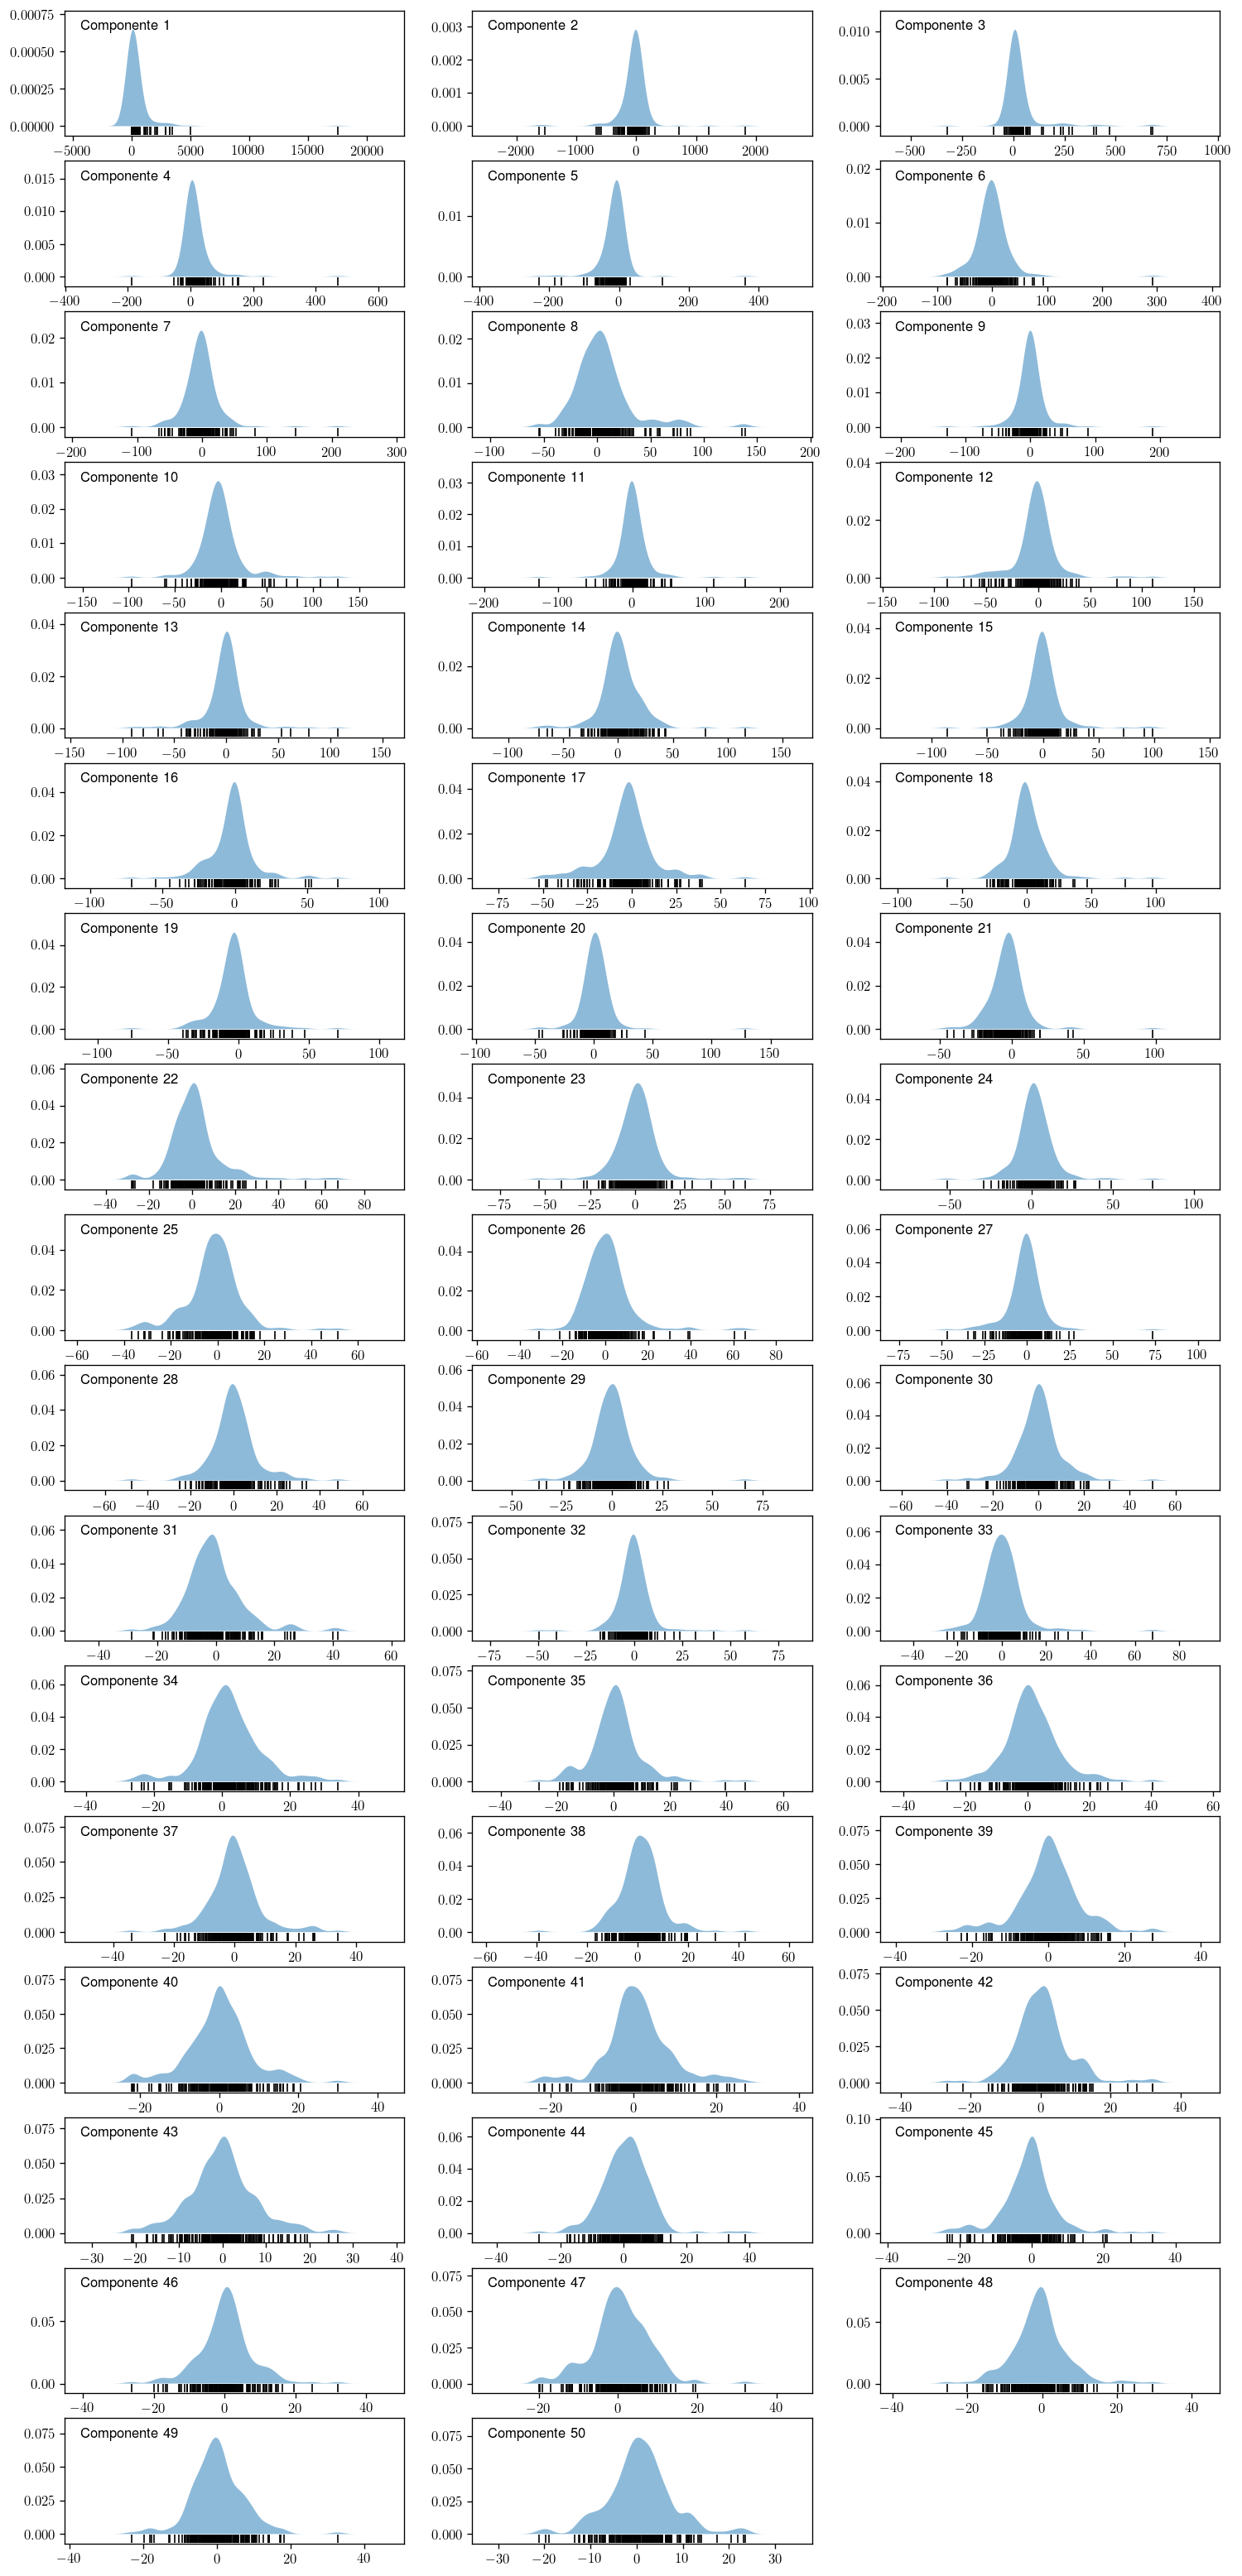

In [66]:
kdes = []
n_components = len(coeffs)
fig = plt.figure(figsize=(15, 2*n_components), dpi=120)
for i in range(n_components):
    ax = fig.add_subplot(n_components,3,i+1)
    margen = (coeffs[i].max()-coeffs[i].min())/4
    x_d = np.linspace(coeffs[i].min()-margen, coeffs[i].max()+margen, 1000)
    
    # instantiate and fit the KDE model
    kde = KernelDensity(bandwidth=margen/8, kernel='gaussian')
    kde.fit(coeffs[i][:, None])

    kdes.append(kde)
    
    # score_samples returns the log of the probability density
    logprob = kde.score_samples(x_d[:, None])

    plt.fill_between(x_d, np.exp(logprob), alpha=0.5)
    plt.plot(coeffs[i], np.full_like(coeffs[i], -0.05*np.exp(logprob).max()), '|k', markeredgewidth=1)
    plt.text(coeffs[i].min()-margen,np.exp(logprob).max()*1,"Componente " + str(i+1))
    plt.ylim(-0.1*np.exp(logprob).max(), np.exp(logprob).max()*1.2)